## Factorization 15

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
import time

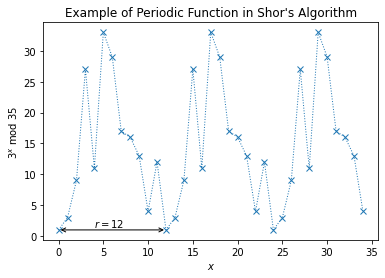

In [26]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate('', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate('$r=%i$' % r, xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

In [27]:
# In this example we work with a = 7 and N = 15
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [28]:
def modular_exponentiation(given_circuit, n, m, a):
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    for x in range(n):
        exponent = 2**x
        given_circuit.append(a_x_mod15(a, exponent), 
                     [x] + list(range(n, n+m))) # last part is target
    ### WRITE YOUR CODE BETWEEN THESE LINES - END

In [29]:
# Specify variables
n_count = 8  # number of counting qubits
a = 7

In [30]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

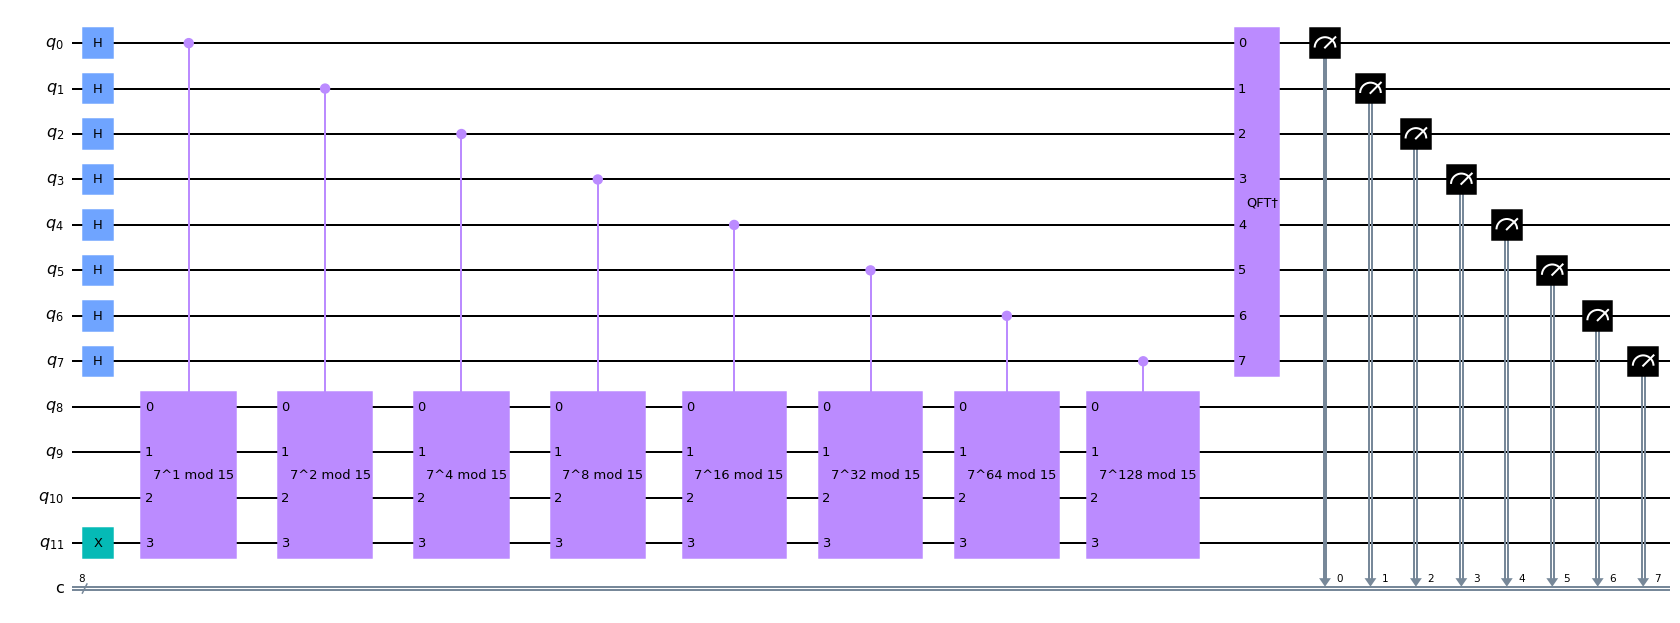

In [31]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw("mpl",fold=-1,)  # -1 means 'do not fold'

In [32]:
aer_sim = Aer.get_backend('aer_simulator')

start = time.time()
t_qc = transpile(qc, aer_sim)
results = aer_sim.run(t_qc).result()
counts = results.get_counts()
end = time.time()
print(end - start)

1.355013370513916


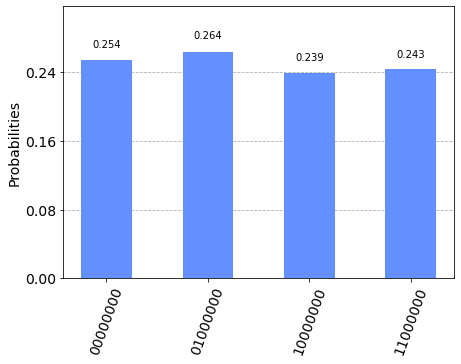

In [33]:
plot_histogram(counts)

In [45]:
counts

{'01000000': 270, '11000000': 249, '00000000': 260, '10000000': 245}

In [47]:
listr = []
 
# appending all the values in the list
for value in counts.values():
    listr.append(value)
# Standard deviation of list
# Using sum() + list comprehension
sum(listr)

1024

In [48]:
listr = []
 
# appending all the values in the list
for value in counts.values():
    listr.append(value/1024)
# Standard deviation of list
# Using sum() + list comprehension
mean = sum(listr) / len(listr)
variance = sum([((x - mean) ** 2) for x in listr]) / len(listr)
res = variance ** 0.5
print(res)

0.009543369280123079


In [43]:
# declaring an empty list
listr = []
 
# appending all the values in the list
for value in counts.values():
    listr.append(value)

# Standard deviation of list
# Using sum() + list comprehension
mean = sum(listr) / len(listr)
variance = sum([((x - mean) ** 2) for x in listr]) / len(listr)
res = variance ** 0.5
print(res)

9.772410142846033


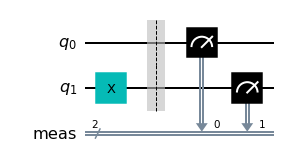

In [10]:
qc_trial = QuantumCircuit(2)
qc_trial.x(1)
qc_trial.measure_all()
qc_trial.draw("mpl")

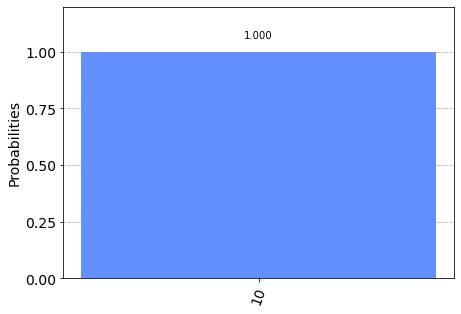

In [11]:
tran_qc = transpile(qc_trial, aer_sim)
results = aer_sim.run(tran_qc).result()
counts_trial = results.get_counts()
plot_histogram(counts_trial)

In [12]:
for output in counts:
    print(output)
    print(int(output, 2))
print(counts)

01000000
64
11000000
192
10000000
128
00000000
0
{'01000000': 272, '11000000': 251, '10000000': 229, '00000000': 272}


In [34]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  01000000(bin) =  64(dec)   64/256 = 0.25
1  11000000(bin) = 192(dec)  192/256 = 0.75
2  00000000(bin) =   0(dec)    0/256 = 0.00
3  10000000(bin) = 128(dec)  128/256 = 0.50


In [35]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

In [36]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

In [37]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.25      1/4            4
1   0.75      3/4            4
2   0.00      0/1            1
3   0.50      1/2            2


In [38]:
def qpe_amod15(a, backend):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
#     aer_sim = Aer.get_backend('aer_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, backend)
    result = aer_sim.run(t_qc, shots=1, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [39]:
aer_sim = Aer.get_backend('aer_simulator')
phase = qpe_amod15(a,aer_sim) # Phase = s/r
Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r

Register Reading: 11000000
Corresponding Phase: 0.750000


Fraction(3, 4)

In [19]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

2


In [20]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[1, 1]


In [21]:
def get_results(a,N,backend):
    factor_found = False
    attempt = 0
    while not factor_found:
        attempt += 1
        print("\nAttempt %i:" % attempt)
        phase = qpe_amod15(a,backend) # Phase = s/r
        frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
        r = frac.denominator
        print("Result: r = %i" % r)
        if phase != 0:
            # Guesses for factors are gcd(x^{r/2} ±1 , 15)
            guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
            print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
            for guess in guesses:
                if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                    print("*** Non-trivial factor found: %i ***" % guess)
                    factor_found = True
    pass

In [22]:
get_results(7,15,aer_sim)


Attempt 1:
Register Reading: 11000000
Corresponding Phase: 0.750000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


##  Quantum Hardware solution

In [23]:
from qiskit import IBMQ
# TOKEN = "b2ecf36021939c29507a4bb36f4d9de097cf476a194db995b0f087742b7b12b6d6ade1d880f929039140e9c2c94ab35607be0122f9abb0ea38d914d911092223"
# IBMQ.save_account(TOKEN)
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

In [24]:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]